In [1]:
import ee
import pandas as pd
import plotnine
from plotnine import *

import sys
import itertools
from tqdm.auto import tqdm

from dfply import *

In [2]:
# authenticate earthengine api
ee.Initialize()

In [3]:
# append sys_path, and import custom moduls
sys.path.append('./')
sys.path.append('../Step_1_UNET_predict_future_urbanization/torch_modules')

from Modules.Modules import filter_exclude, get_img_df
from Modules.Parallize_df import parallelize_dataframe
from Global_Variables import proj_yr_selected

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# the NCP image mask
NCP_img_mask = ee.ImageCollection("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992").first().mask()
NCP_shp = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the pixel size for exporting img later
one_GAEZ_img = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical")
GAEZ_pix_scale = one_GAEZ_img.projection().nominalScale().getInfo()

# read the corrected GAEZ_2010_cropland
GAEZ_cropland_2020_corrected = pd.read_pickle('./result_csv/GAEZ_cropland_2020_corrected.pkl')

In [29]:
# read yearbook cropland area
yearbook_area = pd.read_csv('./result_csv/yearbook_area.csv')

# get the sum of yearbook cropland area records
yearbook_area_sum_province = yearbook_area.groupby(['Province','year']).sum(numeric_only=True).reset_index()
yearbook_area_sum = yearbook_area.groupby(['year']).sum(numeric_only=True).reset_index()

# get the total yearbook cropland area for each province
yearbook_area_province_sum_2020 = yearbook_area_sum_province >> mask(X.year == 2020) \
                       >> drop(['year']) >> rename(area_yearbook_2010_kha='area_yearbook_kha')

### 1) Explore the urban_encroachment and cropland_increase

#### 1-1) read data

In [90]:
# 1) urban excroach on cropland 

# 1-1) the img
urban_encroach_img = pd.read_pickle('./result_csv/urban_encroach_img.pkl')
# 1-2) the data
cropland_area_after_encroachment = pd.read_csv('./result_csv/cropland_area_after_encroachment.csv')
# get the total cropland area
cropland_area_after_encroachment_sum = cropland_area_after_encroachment.groupby(['Scenario','year','Province']).sum().reset_index()


# 2) cropland_increase imgs
reclamation_each_pix_mosaic = pd.read_pickle('./result_csv/reclamation_each_pix_mosaic.pkl')
# 2-2) cropland increase hist df
cropland_increase_province = pd.read_csv('./result_csv/cropland_increase_province.csv')
# 2-3) cropland increase pred df
cropland_increase_since_2020 = pd.read_csv('./result_csv/cropland_increase_since_2020.csv')


# 3) the encroachment df
urban_encroachment_area_df = pd.read_csv('./result_csv/urban_encroachment_area_df.csv')

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


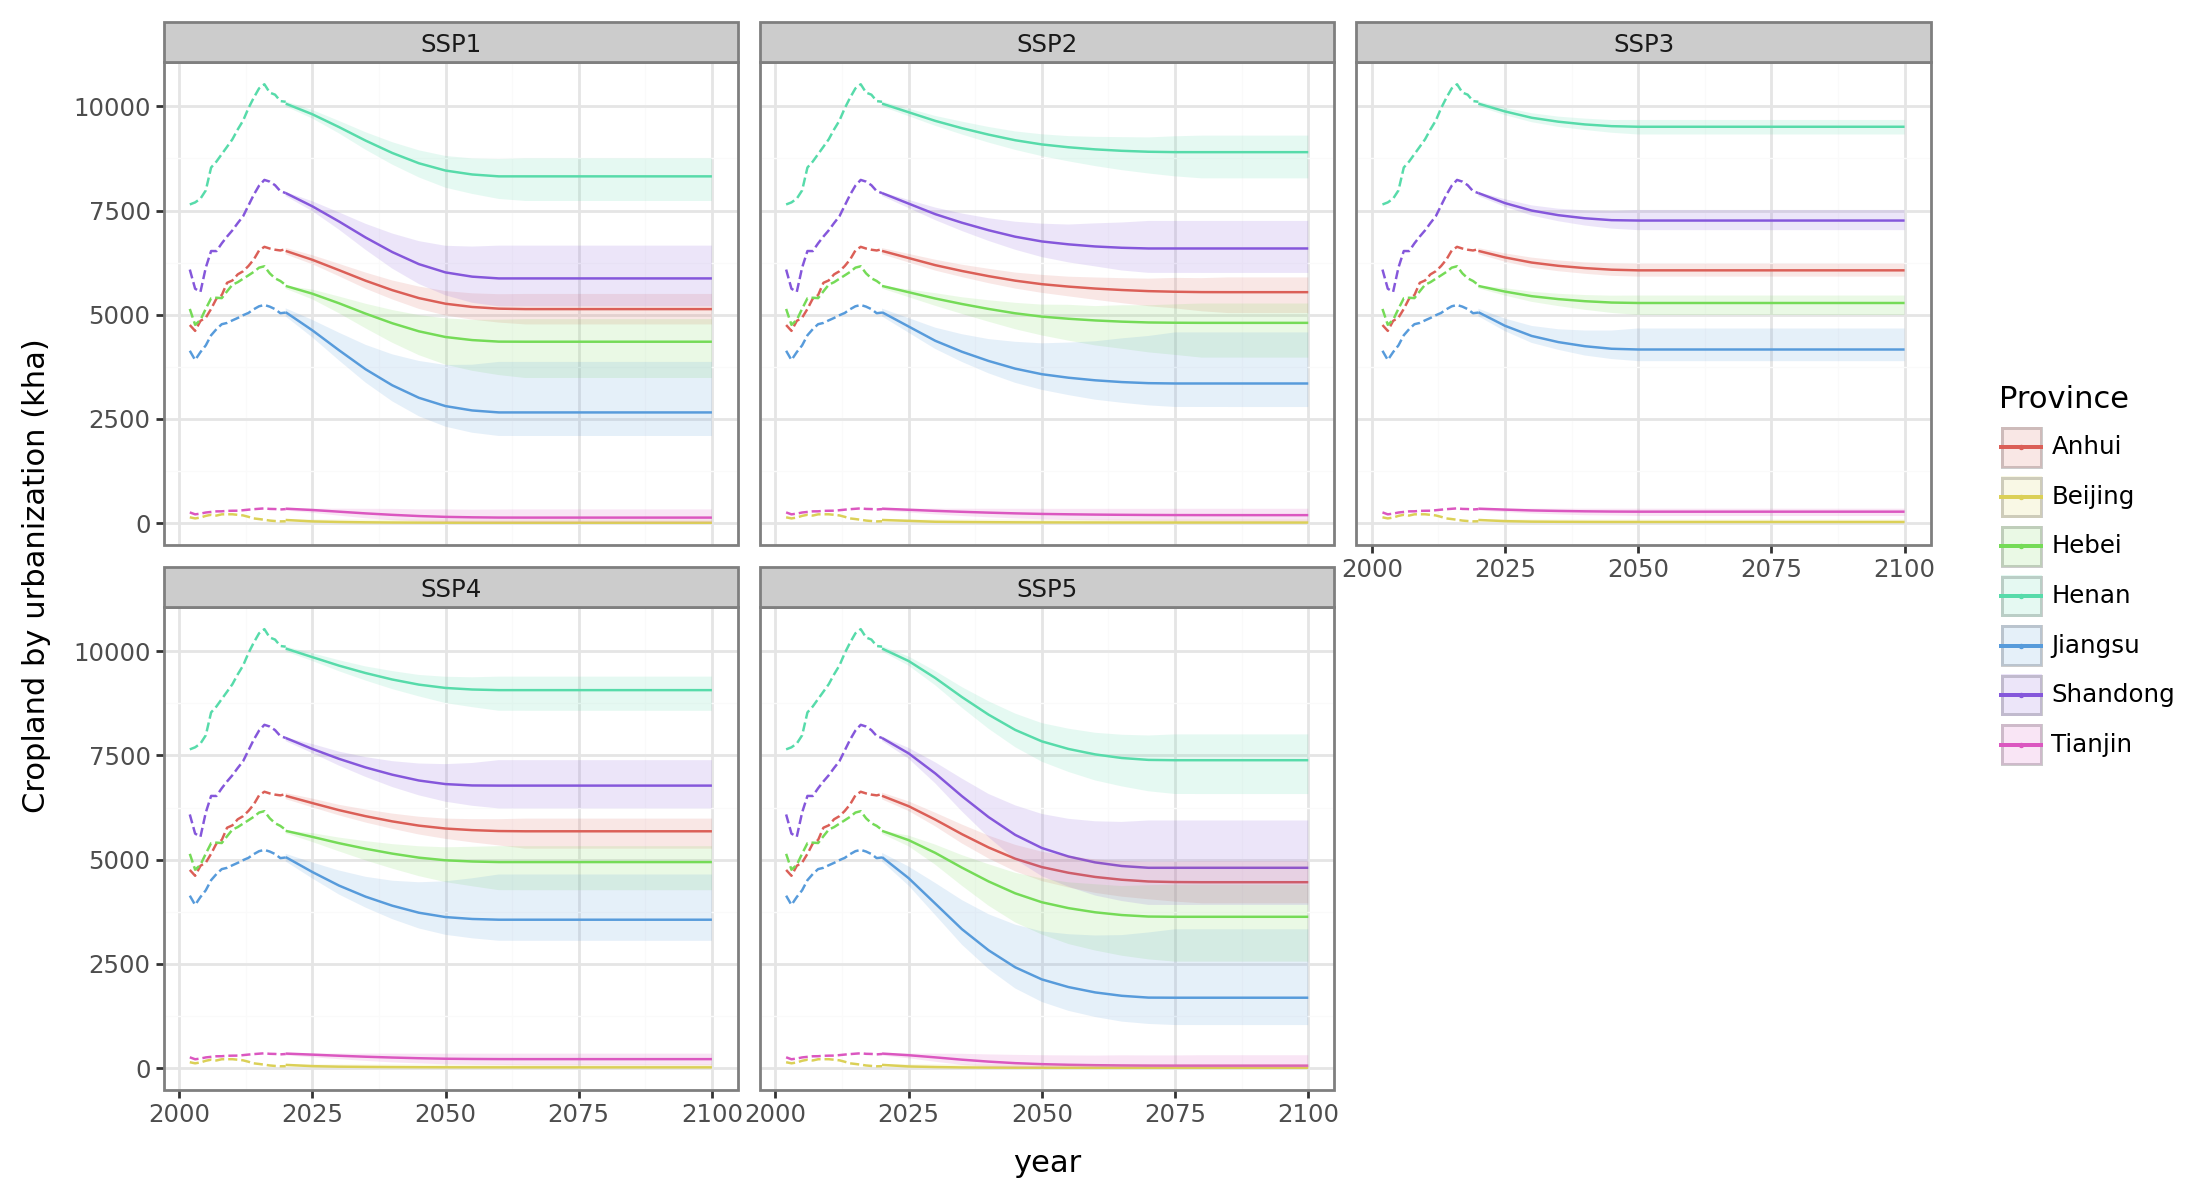

In [60]:
# seperate df for ploting
cropland_area_after_encroachment_sum_hist = cropland_area_after_encroachment_sum \
                      >> mask(X.Scenario == 'Historical') >> drop('Scenario')
cropland_area_after_encroachment_sum_pred = cropland_area_after_encroachment_sum >> mask(X.Scenario != 'Historical')                     


# plot the area change
plotnine.options.figure_size = (11,6)
plotnine.options.dip = 100

# plot the cropland_area_after_encroachment_sum
(ggplot()
 # yearbook cropland area
 + geom_line(yearbook_area_sum_province,aes(x='year',y='area_yearbook_kha',color='Province'),linetype='dashed')
 # cropland after urban encroachment hist
 + geom_point(cropland_area_after_encroachment_sum_hist,aes(x='year',y='area_after_encroachment_kha',color='Province'),size=0.1)
 # cropland after urban encroachment pred
 + geom_line(cropland_area_after_encroachment_sum_pred,aes(x='year',y='area_after_encroachment_kha',color='Province'))
 + geom_ribbon(cropland_area_after_encroachment_sum_pred,
          aes(x='year',ymax='area_after_encroachment_kha_top',ymin='area_after_encroachment_kha_bot',fill='Province'),alpha=0.15)
 + facet_wrap(['Scenario'],ncol=3)
 + theme_bw()
 + theme(subplots_adjust={'wspace': 0.15})
 + ylab('Cropland by urbanization (kha)')
 )


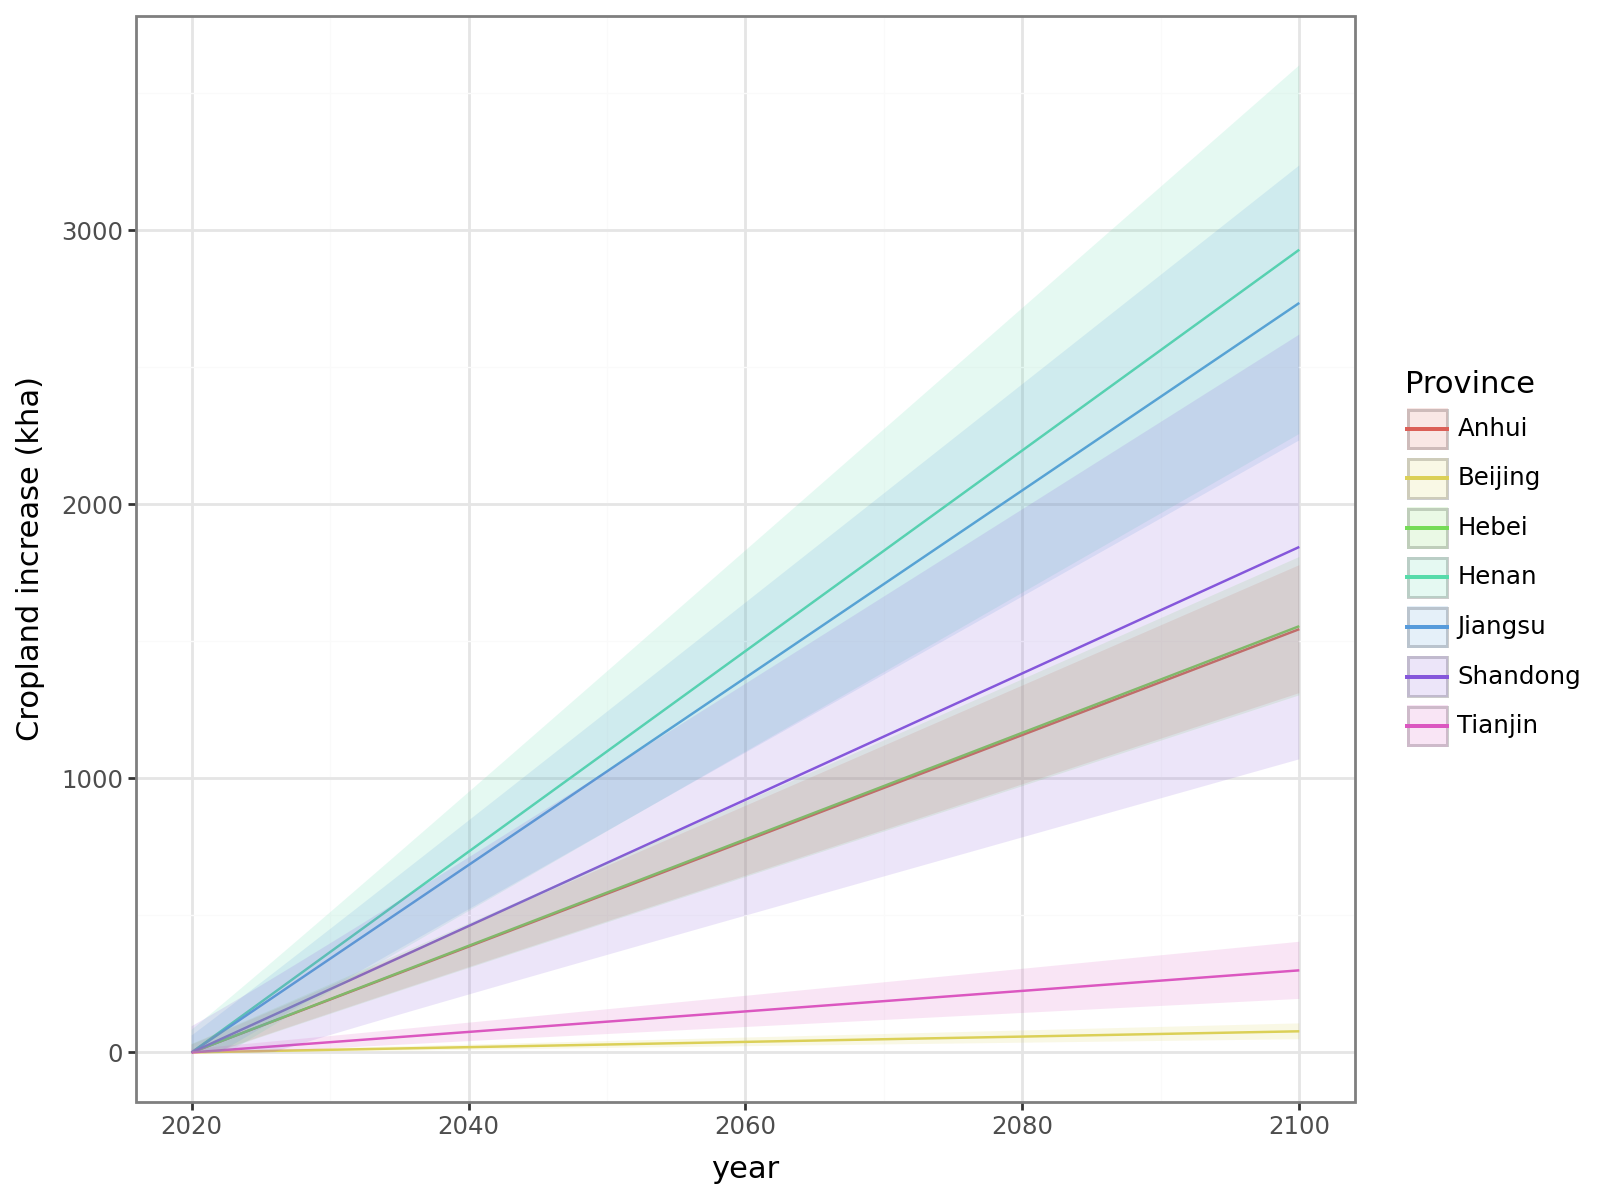

In [61]:
# seperate df for ploting
df_validate_pred = cropland_increase_since_2020 >> mask(X.year > 2015)   

# plot the area change
plotnine.options.figure_size = (8,6)
plotnine.options.dip = 100

(ggplot()
 # pred cropland increase
 + geom_line(df_validate_pred,aes(x='year',y='area_kha',color='Province'))
 + geom_ribbon(df_validate_pred,aes(x='year',ymin='area_kha_bot',ymax='area_kha_top',fill='Province'),alpha=0.15)
 + theme_bw()
 + ylab('Cropland increase (kha)')    
)

#### 1-2) Combine urban encrochment with cropland increase

In [62]:
# compute the total croppand area
total_cropland_2020_img = ee.ImageCollection([ee.Image(path).unmask() 
              for path in  GAEZ_cropland_2020_corrected['GAEZ_2020_cropland_corrcted']]).sum()
              
total_cropland_2020_val = total_cropland_2020_img\
              .reduceRegion(reducer='sum', geometry=NCP_shp.geometry(), scale=GAEZ_pix_scale)\
              .getInfo()['b1']

In [63]:
# compute the cropland area change led by urbanization and cropland_development
urban_encroachment_with_cropland_increase = urban_encroachment_area_df.merge(cropland_increase_since_2020) 

urban_encroachment_with_cropland_increase['cropland_delta_kha'] = urban_encroachment_with_cropland_increase['area_kha'] \
                                  - urban_encroachment_with_cropland_increase['encroach_area_kha_mean']
urban_encroachment_with_cropland_increase['cropland_delta_kha_top'] = urban_encroachment_with_cropland_increase['area_kha_top'] \
                                  - urban_encroachment_with_cropland_increase['encroach_area_kha_bot']
urban_encroachment_with_cropland_increase['cropland_delta_kha_bot'] = urban_encroachment_with_cropland_increase['area_kha_bot'] \
                                  - urban_encroachment_with_cropland_increase['encroach_area_kha_top']

urban_encroachment_with_cropland_increase = urban_encroachment_with_cropland_increase \
                          >> select(['Scenario','Province','year','cropland_delta_kha',
                                'cropland_delta_kha_top','cropland_delta_kha_bot'])
                          
# append the yearbook 2010
urban_encroachment_with_cropland_increase = urban_encroachment_with_cropland_increase.merge(yearbook_area_province_sum_2020)

# compute the final area
urban_encroachment_with_cropland_increase = urban_encroachment_with_cropland_increase \
          >> mutate(final_cropland_kha = X.cropland_delta_kha + X.area_yearbook_2010_kha,
                final_cropland_kha_top = X.cropland_delta_kha_top + X.area_yearbook_2010_kha,
                final_cropland_kha_bot = X.cropland_delta_kha_bot	 + X.area_yearbook_2010_kha)

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


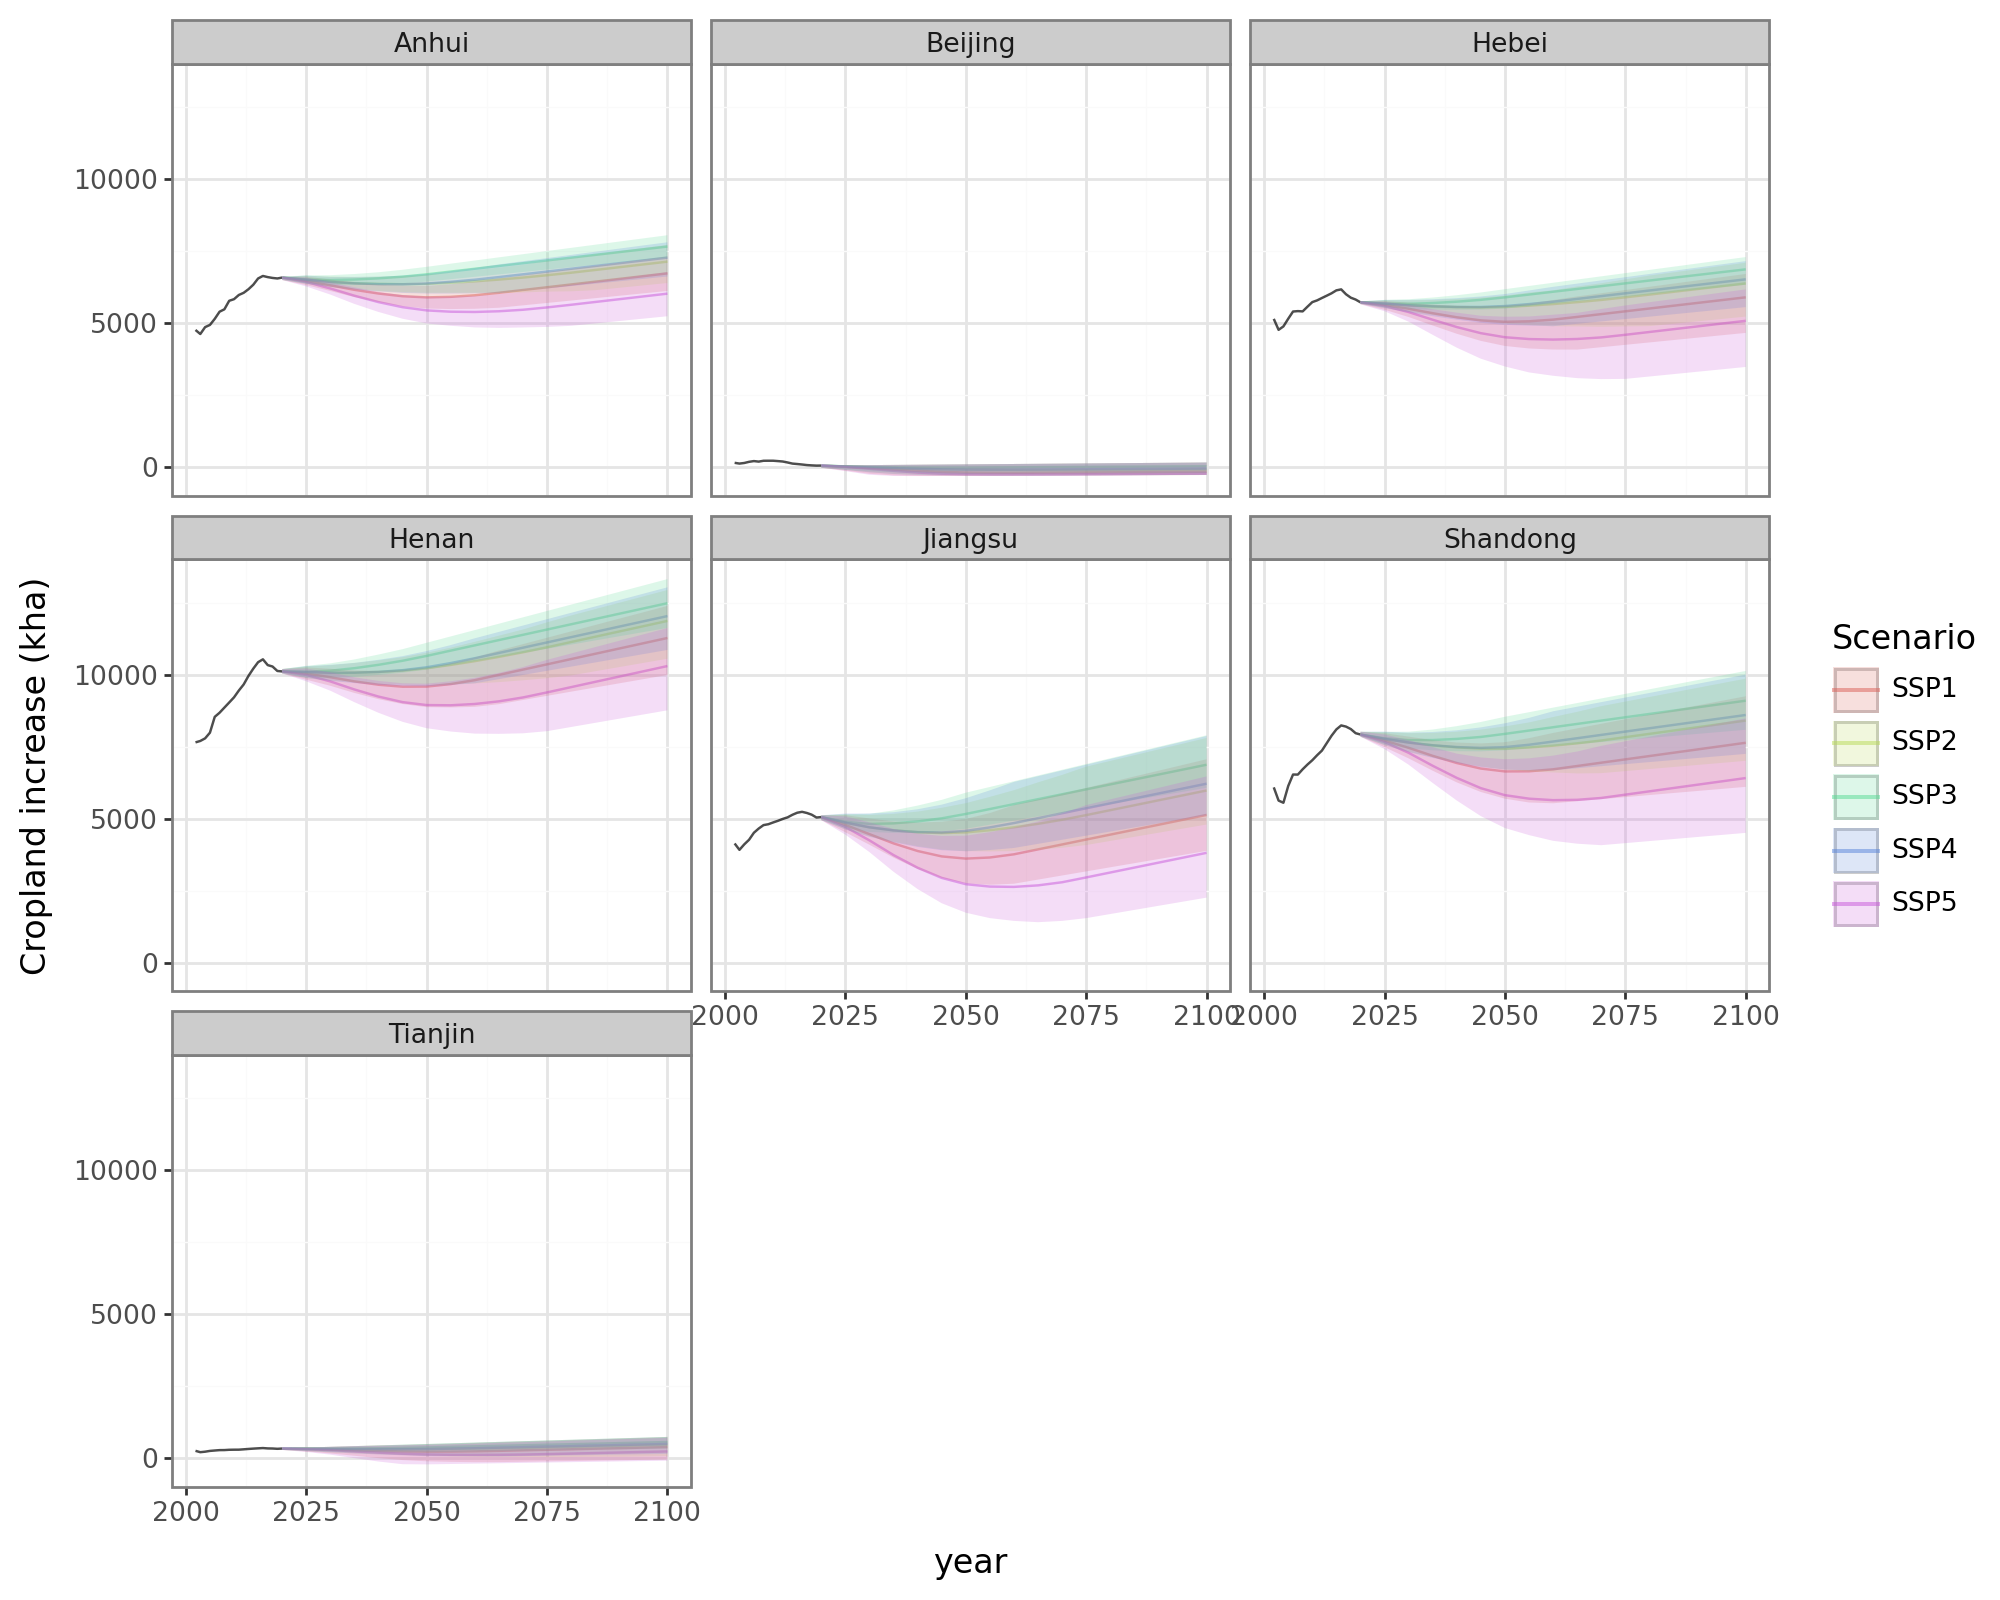

In [64]:
# plot the area change
plotnine.options.figure_size = (10,8)
plotnine.options.dip = 100

(ggplot()
# yearbook cropland
+ geom_line(yearbook_area_sum_province,aes(x='year',y='area_yearbook_kha'),alpha=0.7)
# urban excroachment pred
+ geom_line(urban_encroachment_with_cropland_increase,aes(x='year',y='final_cropland_kha',color='Scenario'),alpha=0.5)
+ geom_ribbon(urban_encroachment_with_cropland_increase,
       aes(x='year',ymin='final_cropland_kha_bot',ymax='final_cropland_kha_top',fill='Scenario'),alpha=0.2)
+ facet_wrap(['Province'],ncol=3)
+ theme_bw(base_size=12)
+ theme(subplots_adjust={'wspace': 0.15})
+ ylab('Cropland increase (kha)')
 )

c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


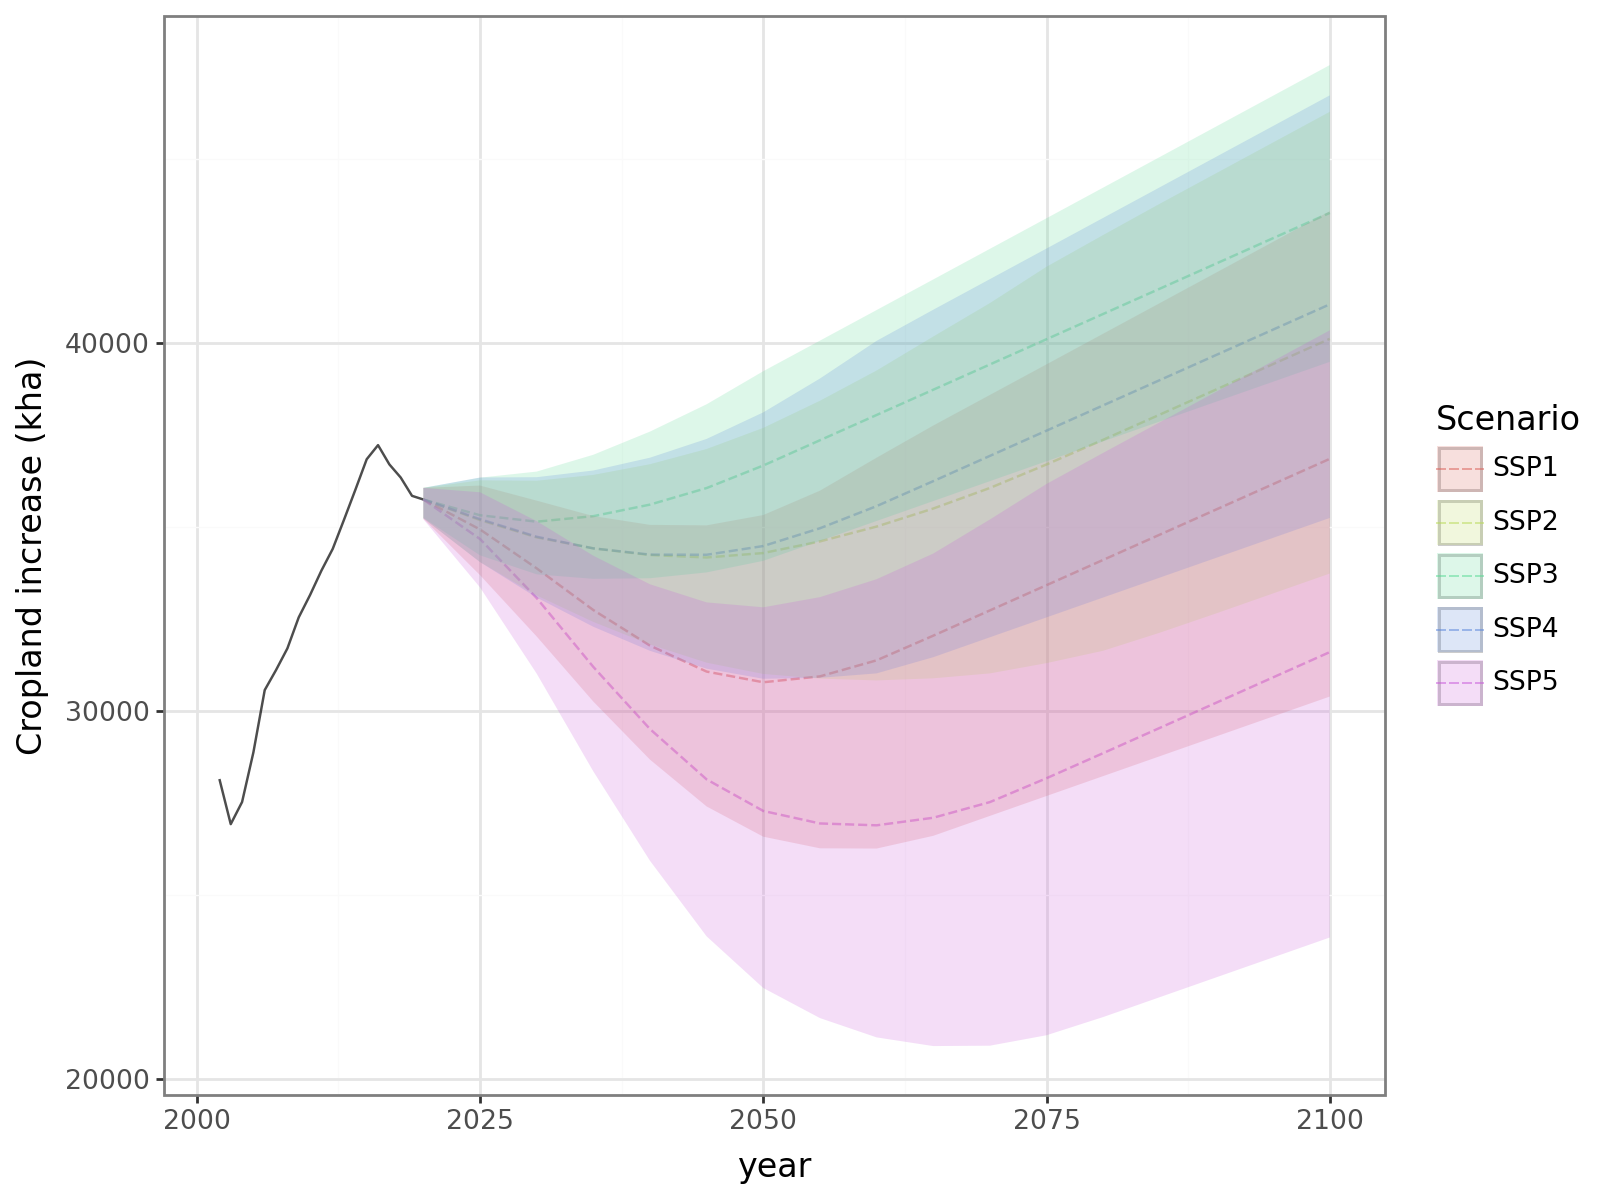

In [65]:
# compute the total change
urban_encroachment_with_cropland_increase_sum = urban_encroachment_with_cropland_increase.groupby(['Scenario','year']).sum(numeric_only=True).reset_index()
yearbook_area_province_sum_total = yearbook_area_sum_province.groupby('year').sum(numeric_only=True).reset_index()

# plot the area change
plotnine.options.figure_size = (8,6)
plotnine.options.dip = 100

(ggplot()
# historical cropland
+ geom_line(yearbook_area_province_sum_total,aes(x='year',y='area_yearbook_kha'),alpha=0.7)
# urban excroachment pred
+ geom_line(urban_encroachment_with_cropland_increase_sum,
            aes(x='year',y='final_cropland_kha',color='Scenario'),alpha=0.5,linetype='dashed')
+ geom_ribbon(urban_encroachment_with_cropland_increase_sum,
       aes(x='year',ymin='final_cropland_kha_bot',ymax='final_cropland_kha_top',fill='Scenario'),alpha=0.2)
# + facet_wrap(['Province'],ncol=3)
+ theme_bw(base_size=12)
+ theme(subplots_adjust={'wspace': 0.15})
+ ylab('Cropland increase (kha)')
 )

### 2) combine urban_encroachment imgs with cropland_increase imgs

#### 2-1) combine urban_encroachment imgs with cropland_increase imgs

In [119]:
# function to combine urban_encroachment with cropland_increase
def combine_encroach_with_increase(row):
  
  # get the area after urban encroachment
  area_after_encroachment_kha       = row['cropland_encroached_by_urban'].select('encroachment_led_farmland')
  
  area_after_encroachment_kha_top = row['cropland_encroached_by_urban'].select('encroachment_led_farmland_top')
  area_after_encroachment_kha_bot = row['cropland_encroached_by_urban'].select('encroachment_led_farmland_bot')
  area_after_encroachment_kha_ci = area_after_encroachment_kha_top.subtract(area_after_encroachment_kha_bot).abs()
  
  # get the area increase from reclimation
  area_increase_kha = row['pix_increase_kha_img']
  
  area_increase_kha_top = row['pix_increase_kha_img_top']
  area_increase_kha_bot = row['pix_increase_kha_img_bot']
  area_increase_kha_ci = area_increase_kha_top.subtract(area_increase_kha_bot).abs()
  
  # get the confidence interval 
  area_ci_kha = area_after_encroachment_kha_ci.multiply(area_after_encroachment_kha_ci).add(area_increase_kha_ci.multiply(area_increase_kha_ci)).sqrt()

  # combine encroach with crop_increase
  future_cropland     = area_after_encroachment_kha.add(area_increase_kha)
  future_cropland_top = future_cropland.add(area_ci_kha)
  future_cropland_bot = future_cropland.subtract(area_ci_kha)
  

  return ee.Image([future_cropland,future_cropland_top,future_cropland_bot])\
          .rename(['final_area_kha','final_area_kha_top','final_area_kha_bot'])

In [120]:
# add reclamation_increase to urban_encroach_img
future_harvested_area = urban_encroach_img.merge(reclamation_each_pix_mosaic)
future_harvested_area['future_farmland_area'] = future_harvested_area\
                        .apply(lambda row: combine_encroach_with_increase(row),1)
future_harvested_area = future_harvested_area >> select(['Scenario','crop','water','year','future_farmland_area'])

# save df to disk
future_harvested_area.to_pickle('./result_csv/future_harvested_area.pkl')

#### 2-2) compute the stats of the final cropland

In [121]:
def compute_future_crop_area(in_df):

  print(' ',end='',flush=True)

  stats_dfs = []

  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    year = row['year']
    ssp = row['Scenario']
    crop = row['crop']
    water = row['water']
    in_img = row['future_farmland_area']

    # get data from ee server
    stats = in_img.reduceRegions(collection = NCP_shp, reducer = 'sum', scale = GAEZ_pix_scale).getInfo()

 
    stats_df = pd.DataFrame({(i['properties']['EN_Name'],year,ssp,crop,water):[i['properties']['final_area_kha'],
                                          i['properties']['final_area_kha_top'],
                                          i['properties']['final_area_kha_bot']] \
                  for i in stats['features']}).T.reset_index()

    stats_df.columns = ['Province','year','ssp','crop','water','final_area_kha','final_area_kha_top','final_area_kha_bot']
      
    
    stats_dfs.append(stats_df)

  out_df = pd.concat(stats_dfs).reset_index(drop=True)
  return out_df

In [ ]:
# instantiate the computation
future_harvested_area_df = parallelize_dataframe(future_harvested_area,compute_future_crop_area,30)

future_harvested_area_df['Province'] = future_harvested_area_df['Province'].astype(str)
future_harvested_area_df['ssp'] = future_harvested_area_df['ssp'].astype(str)
future_harvested_area_df.to_csv('./result_csv/future_harvested_area_df.csv',index=False)

# read saved data
future_harvested_area_df = pd.read_csv('./result_csv/future_harvested_area_df.csv')

In [123]:
# get the sum of cropland area
future_harvested_area_sum_df = future_harvested_area_df.groupby(['ssp','Province','year']).sum(numeric_only=True).reset_index() \
                  >> rename(Scenario='ssp')
future_harvested_area_sum_df.head()

,Scenario,Province,year,final_area_kha,final_area_kha_top,final_area_kha_bot
0,SSP1,Anhui,2020,6530.777119,6701.370552,6360.183686
1,SSP1,Anhui,2025,6416.325493,6676.070364,6156.580622
2,SSP1,Anhui,2030,6266.095698,6615.822895,5916.368500
3,SSP1,Anhui,2035,6110.617155,6559.434575,5661.799734
4,SSP1,Anhui,2040,5983.061744,6511.433119,5454.690369


c:\Users\Jinzhu\miniconda3\envs\gee\Lib\site-packages\plotnine\themes\themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


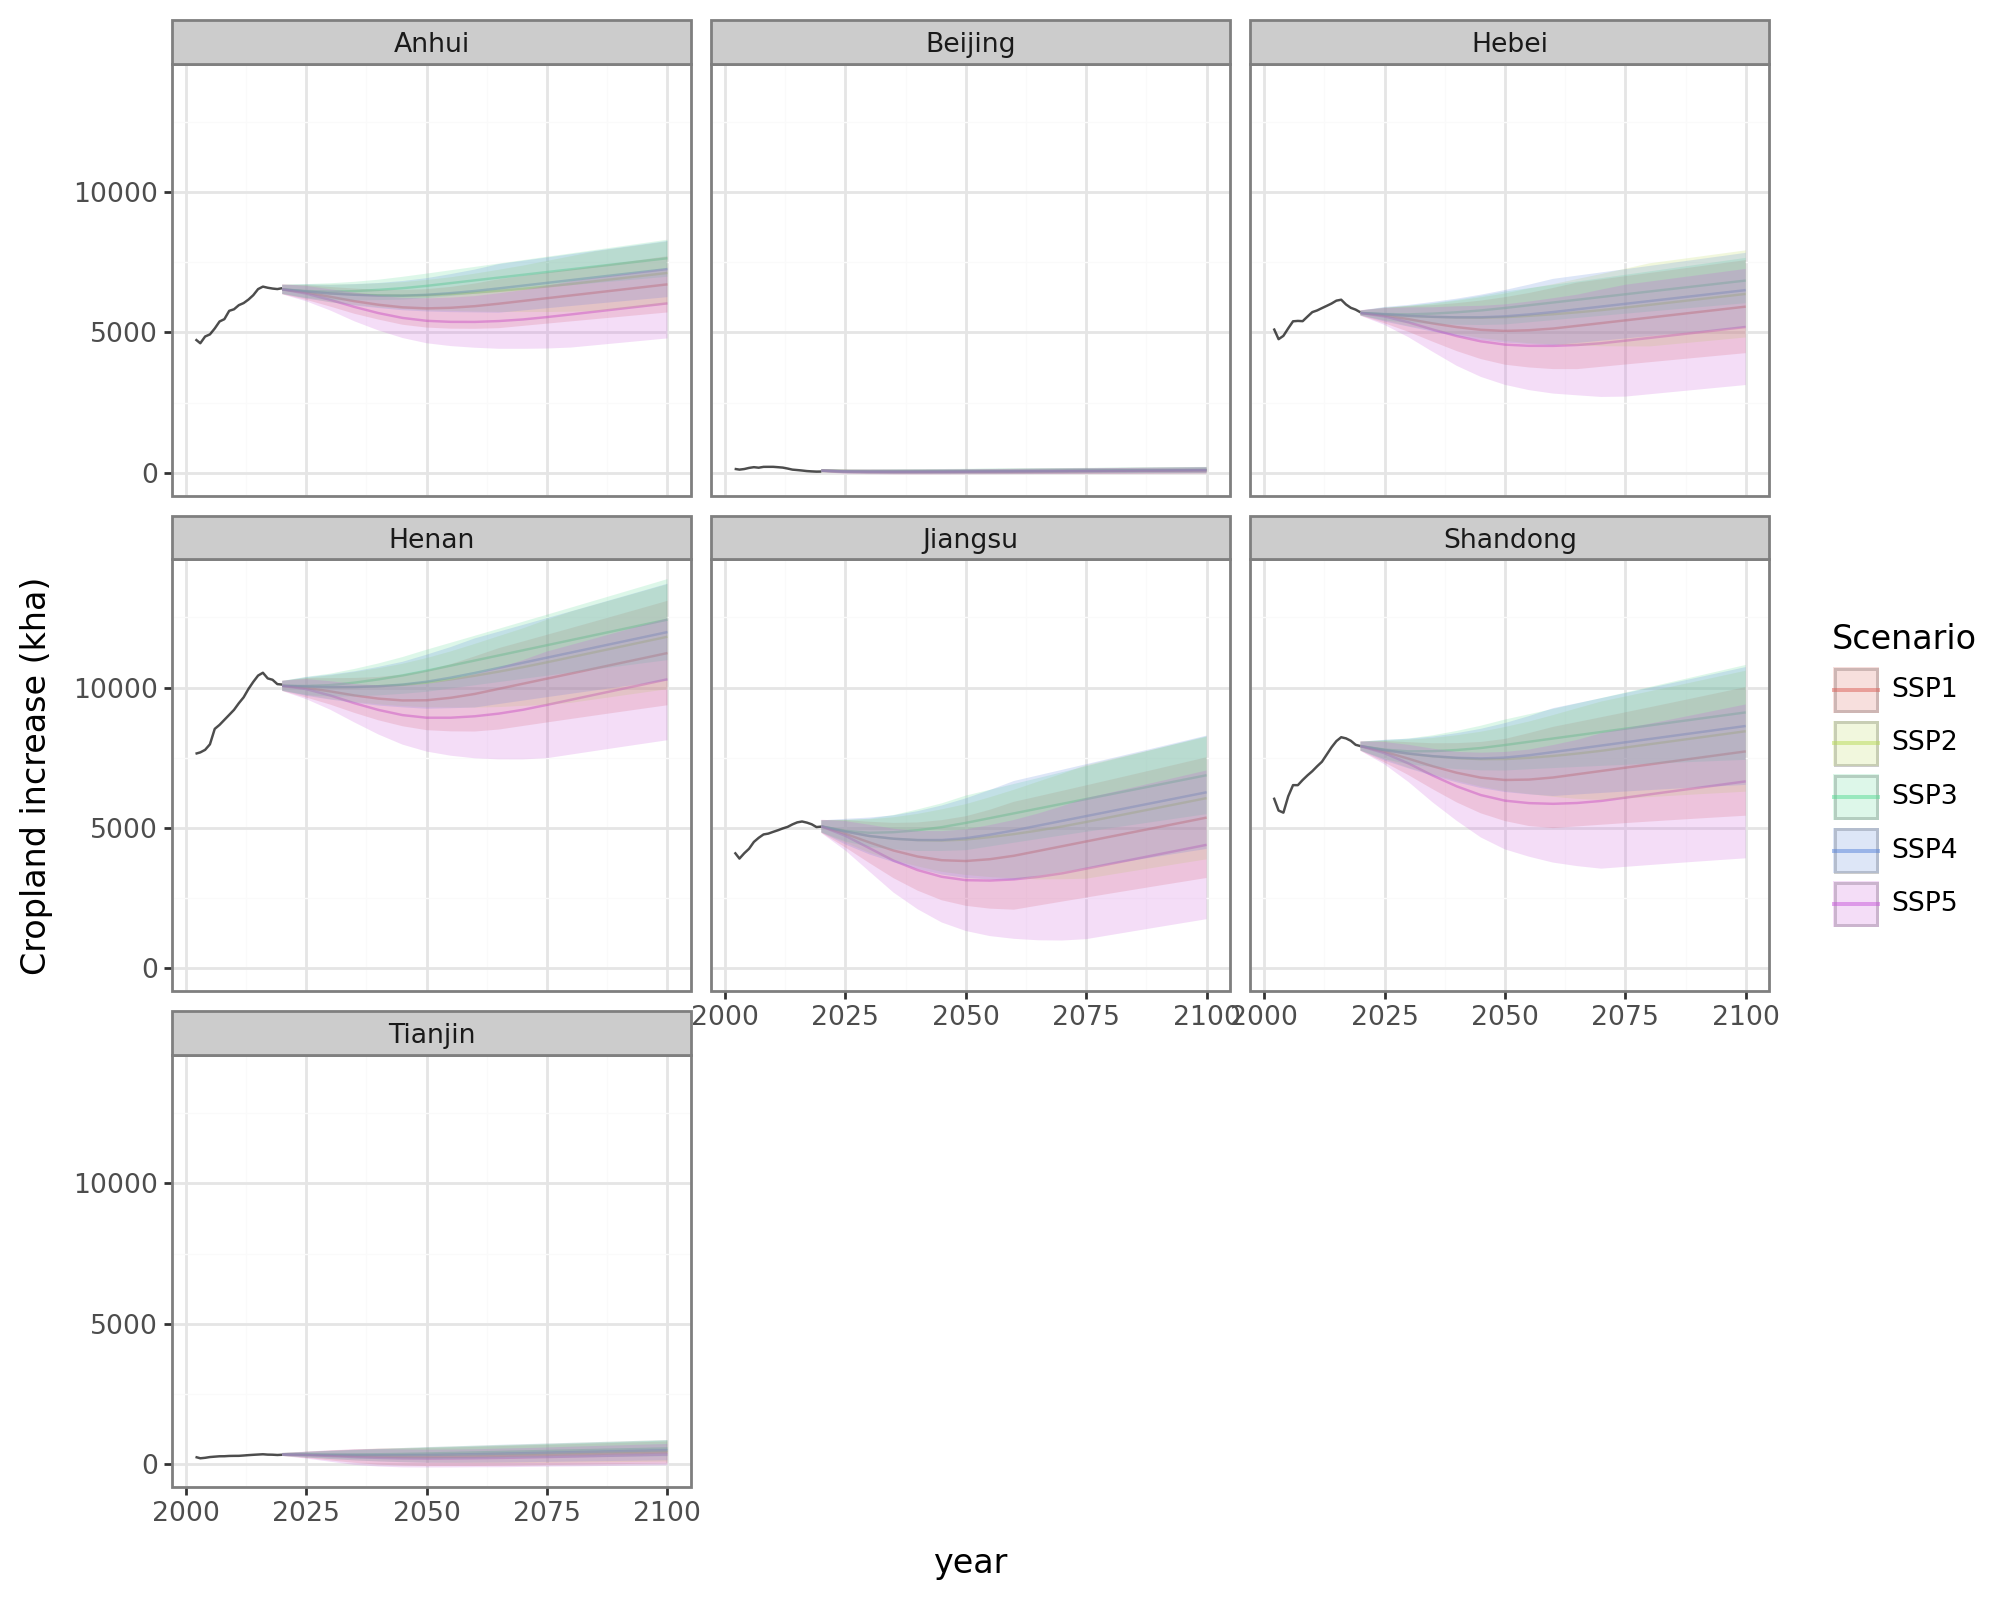

In [124]:
# plot the area change
plotnine.options.figure_size = (10,8)
plotnine.options.dip = 100

(ggplot()
# yearbook cropland
+ geom_line(yearbook_area_sum_province,aes(x='year',y='area_yearbook_kha'),alpha=0.7)
# model cropland pred
+ geom_line(future_harvested_area_sum_df,aes(x='year',y='final_area_kha',color='Scenario'),alpha=0.5)
+ geom_ribbon(future_harvested_area_sum_df,
       aes(x='year',ymin='final_area_kha_bot',ymax='final_area_kha_top',fill='Scenario'),alpha=0.2)
+ facet_wrap(['Province'],ncol=3)
+ theme_bw(base_size=12)
+ theme(subplots_adjust={'wspace': 0.15})
+ ylab('Cropland increase (kha)')
 )

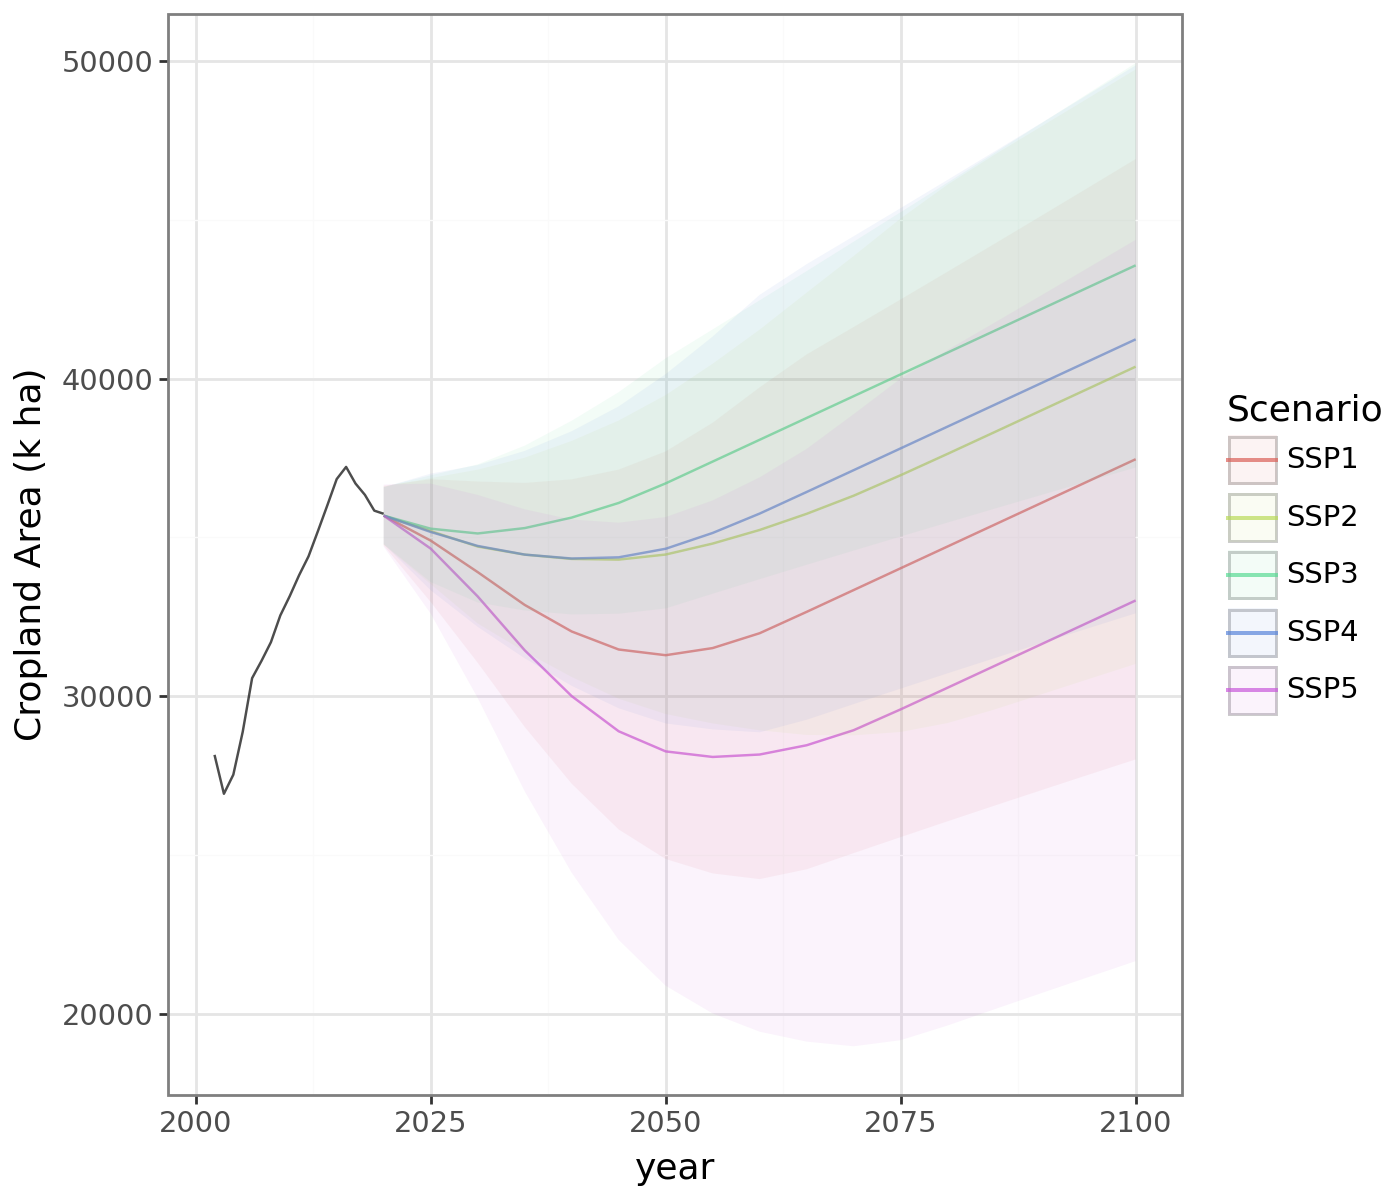

In [125]:
# compute the total change
final_cropland_area_pred_sum = future_harvested_area_sum_df.groupby(['Scenario','year']).sum(numeric_only=True).reset_index()

yearbook_area_province_sum_total = yearbook_area_sum_province.groupby('year').sum(numeric_only=True).reset_index()

# plot the area change
plotnine.options.figure_size = (7,6)
plotnine.options.dip = 100

(ggplot()
# historical cropland
+ geom_line(yearbook_area_province_sum_total,aes(x='year',y='area_yearbook_kha'),alpha=0.7)
# urban excroachment pred
+ geom_line(final_cropland_area_pred_sum,
            aes(x='year',y='final_area_kha',color='Scenario'),alpha=0.7)
+ geom_ribbon(final_cropland_area_pred_sum,
       aes(x='year',ymin='final_area_kha_bot',ymax='final_area_kha_top',fill='Scenario'),alpha=0.07)
# + facet_wrap(['Province'],ncol=3)
# + scale_x_continuous(breaks=range(2000,2101,10))
+ theme_bw(base_size=13)
# yscale from 0 to 1000
# + coord_cartesian(ylim=(0,450))
+ ylab('Cropland Area (k ha)')
 )